In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
f = h5py.File("hubbard_exact.h5", "r")

In [3]:
exact_energy = np.min(f["energies"]).real
print(f"Ground state energy from FCI = {exact_energy}")

Ground state energy from FCI = -1.2360679774997898


In [4]:
listing = os.listdir("data/")
results_files = [f for f in listing if "hubbard_eigvals_" in f]
print(results_files)

['hubbard_eigvals_50_steps.hdf5', 'hubbard_eigvals_1_steps.hdf5', 'hubbard_eigvals_100_steps.hdf5', 'hubbard_eigvals_30_steps.hdf5', 'hubbard_eigvals_200_steps.hdf5', 'hubbard_eigvals_300_steps.hdf5', 'hubbard_eigvals_400_steps.hdf5', 'hubbard_eigvals_10_steps.hdf5', 'hubbard_eigvals_20_steps.hdf5']


In [5]:
dfs = []
for f in results_files:
    df = pd.read_hdf("data/" + f, key="eigenvalues")
    h5_file = h5py.File("data/" + f)
    tau = h5_file["tau"][()]
    steps = h5_file["steps"][()]
    h5_file.close()
    df["tau"] = tau
    df["steps"] = steps
    dfs.append(df)

In [6]:
big_df = pd.concat(dfs)
big_df["rel_error"] = abs(big_df["energy"] - exact_energy) / abs(exact_energy)
print(big_df.head())

   d           eps    energy  num_pos   tau  steps     rel_error
i                                                               
0  3  1.000000e-12 -1.235780        3  0.05     50  2.333772e-04
1  4  1.000000e-12 -1.236068        4  0.05     50  2.691252e-10
2  5  1.000000e-12 -1.236068        4  0.05     50  6.792018e-11
3  6  1.000000e-12 -1.236068        4  0.05     50  4.108408e-11
4  7  1.000000e-12 -1.236068        4  0.05     50  3.204093e-11


In [7]:
df_max_d = big_df[big_df["d"] == max(df["d"])]

In [8]:
# Get row with the lowest relative error.
big_df[big_df['rel_error'] == big_df['rel_error'].min()]

,d,eps,energy,num_pos,tau,steps,rel_error
i,,,,,,,
13,16,1.000000e-12,-1.236068,7,0.05,400,3.592757e-13


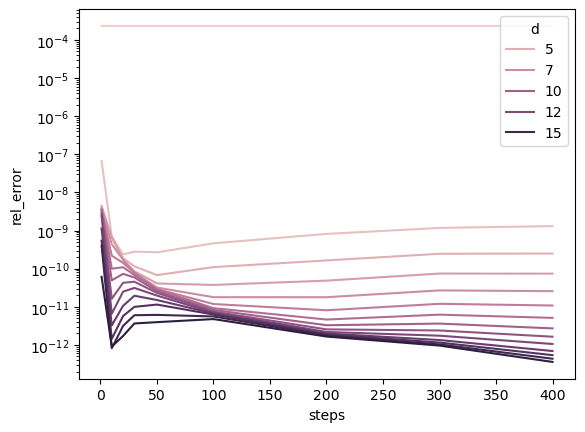

In [9]:
fig, ax = plt.subplots()
sns.lineplot(data=big_df, x="steps", y="rel_error", hue="d")
ax.set_yscale("log")
#plt.show()
plt.savefig("hubbard_error.pdf")